## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail</a> is a transnational dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Source
UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/online+retail

## Business Goal
To segment the Customers based on RFM so that the company can target its customers efficiently.

## Methodology

1. [Reading and Understanding the Data](#1) <br>
    a. Creating a Data Dictionary
2. [Data Cleaning](#2)
3. [Data Preparation](#3) <br>
    a. Scaling Variables
4. [Model Building](#4) <br>
    a. K-means Clustering <br>
    b. Finding the Optimal K
5. [Final Analysis](#5)

<a id="1"></a> <br>
### 1 : Reading and Understanding Data

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py 
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# Reading the data on which analysis needs to be done
retail = pd.read_csv('dataset/OnlineRetail.csv', encoding='ISO-8859-1')

#### Data Dictionary 

First Header  | Definition    |  Description  | Data Type
------------- | ------------- | ------------- | -------------
InvoiceNo  | Invoice number | A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. | Nominal
StockCode | Product (item) code | A 5-digit integral number uniquely assigned to each distinct product. | Nominal
Description | Product (item) name | Name of Product | Nominal
Quantity | Quantity | The quantities of each product (item) per transaction | Numeric
InvoiceDate | Invoice Date and time | The day and time when each transaction was generated. | Numeric
UnitPrice | Unit price | Product price per unit in sterling. | Numeric
CustomerID | Customer number | A 5-digit integral number uniquely assigned to each customer. | Nominal
Country | Country name | The name of the country where each customer resides. | Nominal

In [3]:
#show all columns on output
pd.set_option('display.max_columns', None)

In [4]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
# shape of df
retail.shape

(541909, 8)

In [6]:
# df description
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


<a id="2"></a> <br>
### 2 : Data Cleaning

In [8]:
# # Convert InvoiceDate to datetime
# retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [9]:
# Calculating the Missing Values % contribution in DF
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [10]:
# Droping rows having missing values
retail = retail.dropna()
retail.shape

(406829, 8)

In [11]:
# Changing the datatype of Customer Id as per Business understanding
retail['CustomerID'] = retail['CustomerID'].astype(str)
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.9+ MB


<a id="3"></a> <br>
### 3 : Data Preparation

#### Customers will be analyzed based on 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [12]:
# New Attribute : Monetary
retail['Amount'] = retail['Quantity'] * retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head(5)

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [13]:
# New Attribute : Frequency
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head(5)



,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [14]:
# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
print(rfm.shape)
rfm.head(5)

(4372, 3)


,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [15]:
# New Attribute : Recency
# Convert to datetime to proper datatype
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')



In [16]:
# Compute the maximum date to know the last transaction date
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [17]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [18]:
# Compute last transaction date to get the recency of customers
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head(5)

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [19]:
# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head(5)


,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [20]:
# Merge tha dataframes to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p , on='CustomerID', how='inner')

In [21]:
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.<br>
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardization (mean-0, sigma-1) 

Here we execute Standard Scaling.

In [22]:
# Rescaling the Attributes
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4372, 3)

## <span style="color: red;">Execute MinMax Scaling in the next box</span> 

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Rescaling the Attributes
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate 
scaler = MinMaxScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.shape


(4372, 3)

In [24]:
rfm_df_scaled.head(5)

,0,1,2
0,0.015109,0.000125,0.871314
1,0.030297,0.022676,0.002681
2,0.021442,0.003758,0.198391
3,0.021303,0.009020,0.048257
4,0.016288,0.002005,0.828418


<a id="4"></a> <br>
### 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [28]:
# k-means with some arbitrary k
Kmeans = KMeans(n_clusters=4, max_iter=50)
Kmeans.fit(rfm_df_scaled)

c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KMeans(max_iter=50, n_clusters=4)

In [29]:
Kmeans.labels_

array([1, 3, 0, ..., 3, 3, 3])

In [30]:
# Create a K-means function here
def K_Means(X, n):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model = KMeans(n)
    model.fit(X)
    cluster_labels = model.predict(X)
    cent = model.cluster_centers_
    return cluster_labels, cent

In [31]:
clust_labels, cent = K_Means(rfm_df, 3)
kmeans = pd.DataFrame(clust_labels)
rfm_df.insert((rfm_df.shape[1]), 'kmeans', kmeans)


In [32]:
rfm_df.head(5)

,Amount,Frequency,Recency,kmeans
0,0.00,2,325,1
1,4310.00,182,1,0
2,1797.24,31,74,0
3,1757.55,73,18,0
4,334.40,17,309,1


In [33]:
# Plot your clusters
def Plot3dClustering(n, X, type_c):
    data = []
    clusters = []
    colors = ['rgb(228,26,28)', 'rgb(55,126,184)', 'rgb(77,175,74)']
    
    for i in range(n):
        name = i
        color = colors[i]
        x = X[X[type_c] == i]['Amount']
        y = X[X[type_c] == i]['Frequency']
        z = X[X[type_c] == i]['Recency']
        
        trace = dict(
            name = name,
            x = x, y = y, z = z,
            type = 'scatter3d',
            mode = 'markers',
            marker = dict(size = 3, color = color, line = dict(width = 0)))
        data.append(trace)
        
        cluster = dict(
            color = color,
            opacity = 0.1,
            type = 'mesh3d',
            alphahull = 7,
            name = "y",
            x = x, y = y, z = z)
        data.append(cluster)
        
    layout = dict(
        width = 800,
        height = 550,
        autosize = False,
        title = '3D Clustering Plot',
        scene = dict(
            xaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                title='Amount',
                backgroundcolor = 'rgb(230, 230, 230)',
                ),
            yaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                title='Frequency',
                backgroundcolor = 'rgb(230, 230, 230)',
                ),
            zaxis = dict(
                gridcolor = 'rgb(255, 255, 255)',
                zerolinecolor = 'rgb(255, 255, 255)',
                showbackground = True,
                title='Recency',
                backgroundcolor = 'rgb(230, 230, 230)',
                ),
            aspectratio = dict(x=1, y=1, z=0.7),
            aspectmode = 'manual'
        ),
    )
        
    fig = dict(data = data, layout = layout)
    iplot(fig, filename='3d-scatter-colorscale', validate=False)
    

In [34]:
Plot3dClustering(n=3, X=rfm_df, type_c='kmeans')

## <span style="color: red;">Finding the Optimal Number of Clusters</span> 

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

Text(0.5, 1.0, 'Elbow Method')

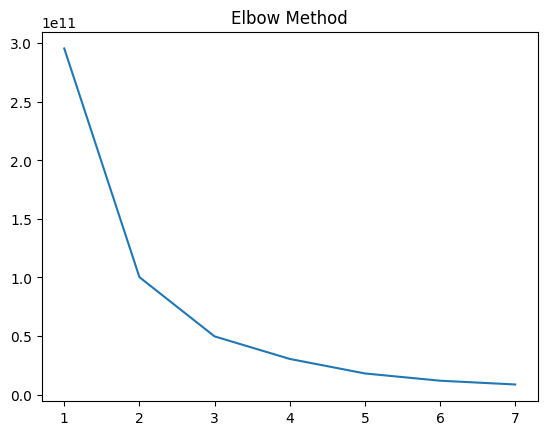

In [35]:
X = rfm_df
wcss = []
for i in range(1,8):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=7, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,8), wcss)
plt.title('Elbow Method')

## <span style="color: red;">Box Plots of Clusters created</span> 

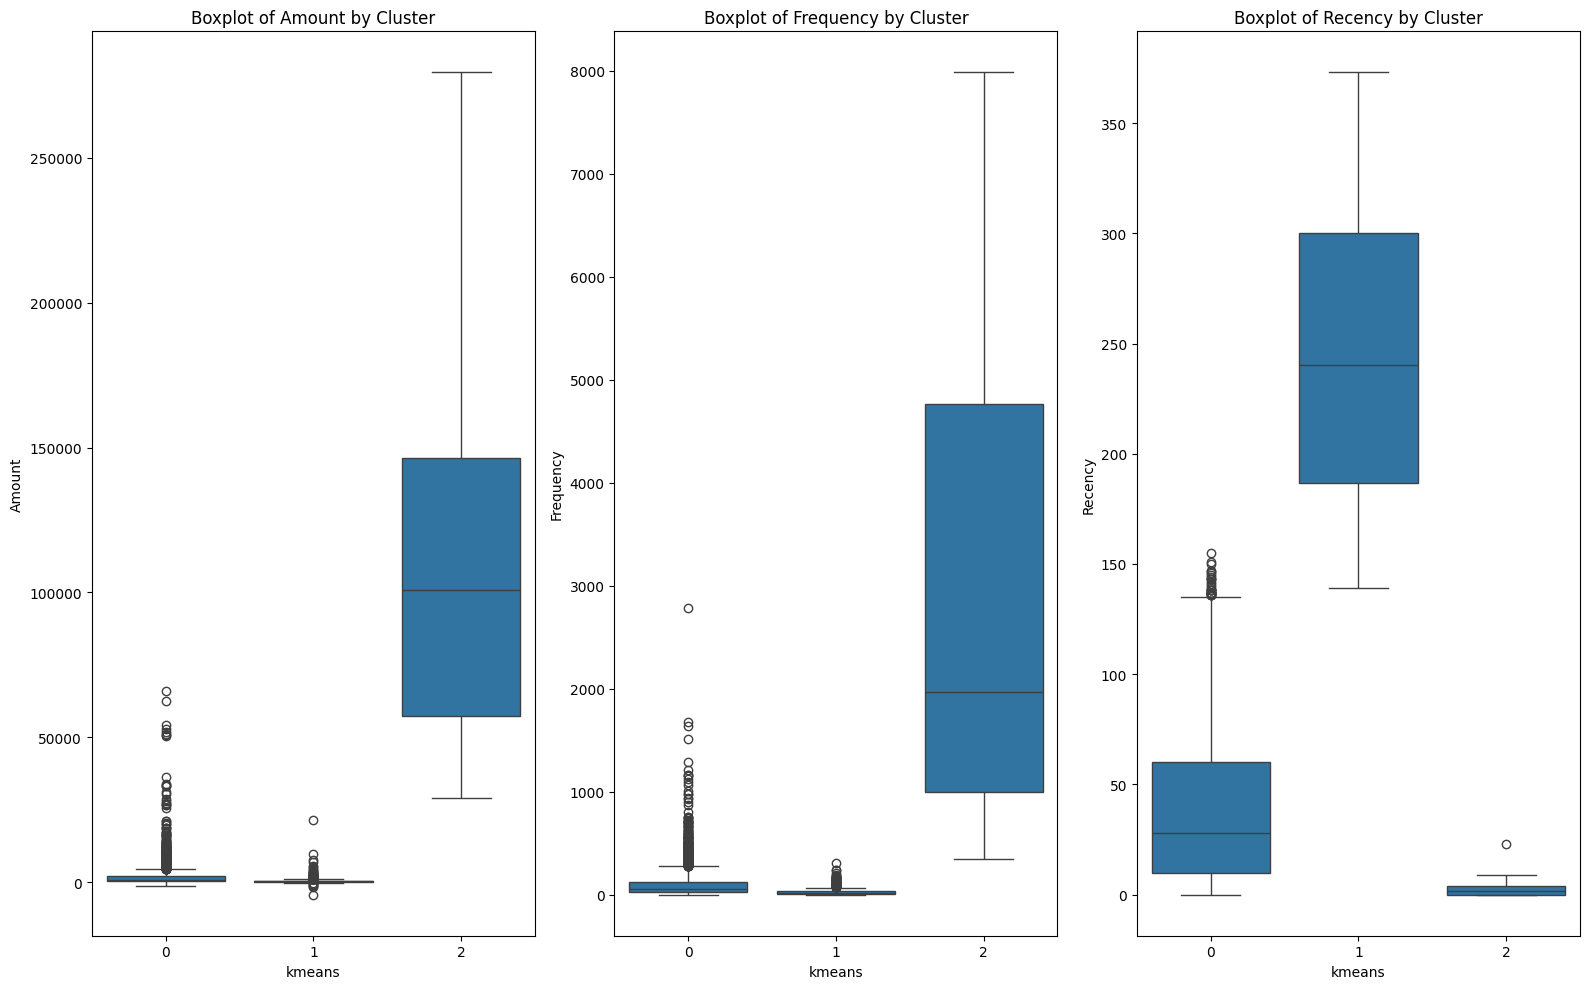

In [37]:
# Creating the plot
plt.figure(figsize=(16, 10))

# Create a subplot for each feature
for i, feature in enumerate(['Amount', 'Frequency', 'Recency'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='kmeans', y=feature, data=rfm_df)
    plt.title(f'Boxplot of {feature} by Cluster')

# Show the plot
plt.tight_layout()
plt.show()


<a id="5"></a> <br>
## Step 5 : Final Analysis

## <span style="color: red;">Findings</span> 

#### Student Name: 4CSC
- Benjamin Francis Abadila
- Angelo Dela Paz
- Carl Mitzchel Padua
- Edjin Jerney Payumo
- Levin Jacob Sta. Cruz